# A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network


# Imports


In [94]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt


import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax,LSTM
from keras.optimizers import Adam,SGD 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

In [95]:
import matplotlib.pyplot as plt
from matplotlib import rcParams


# matplotlib Settings

In [96]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Methods Definitions

In [97]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


# Variables Definitions

In [98]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Prepere Input Files

In [99]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [100]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

# Data Extraction and Preprocessing

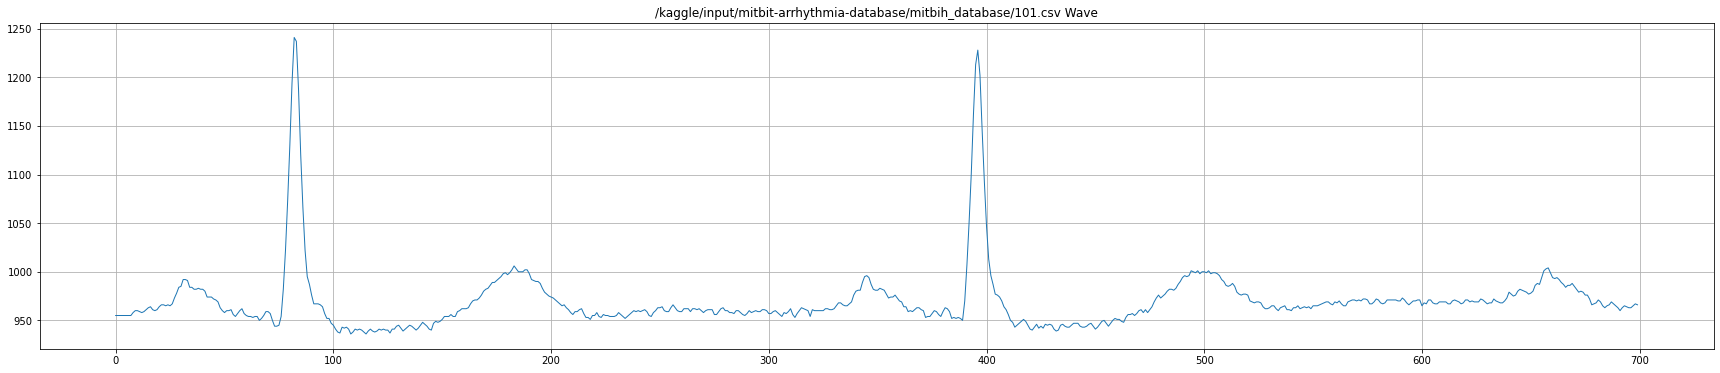

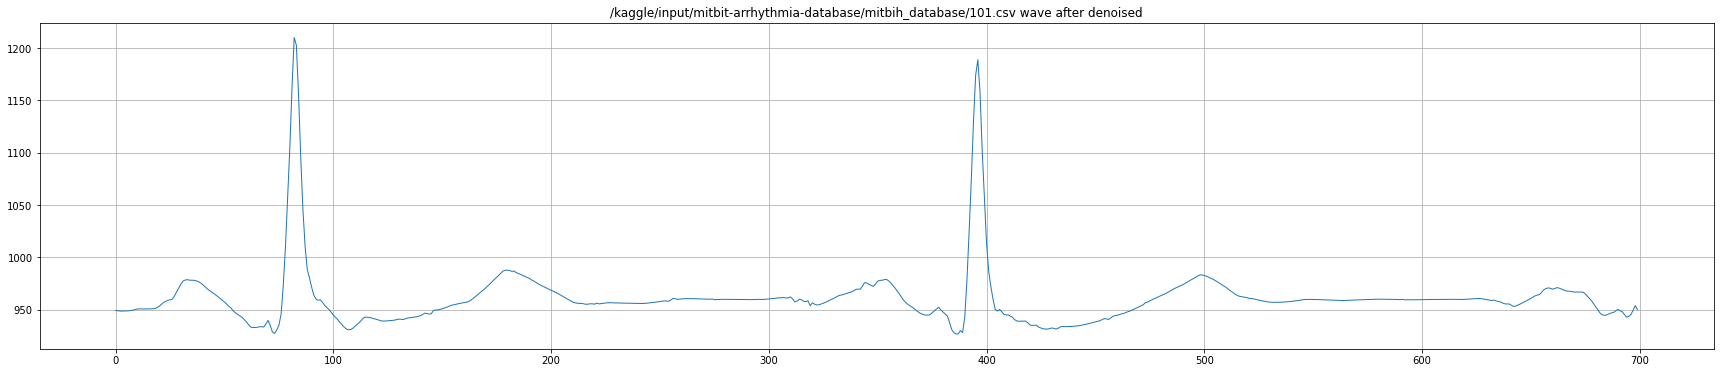

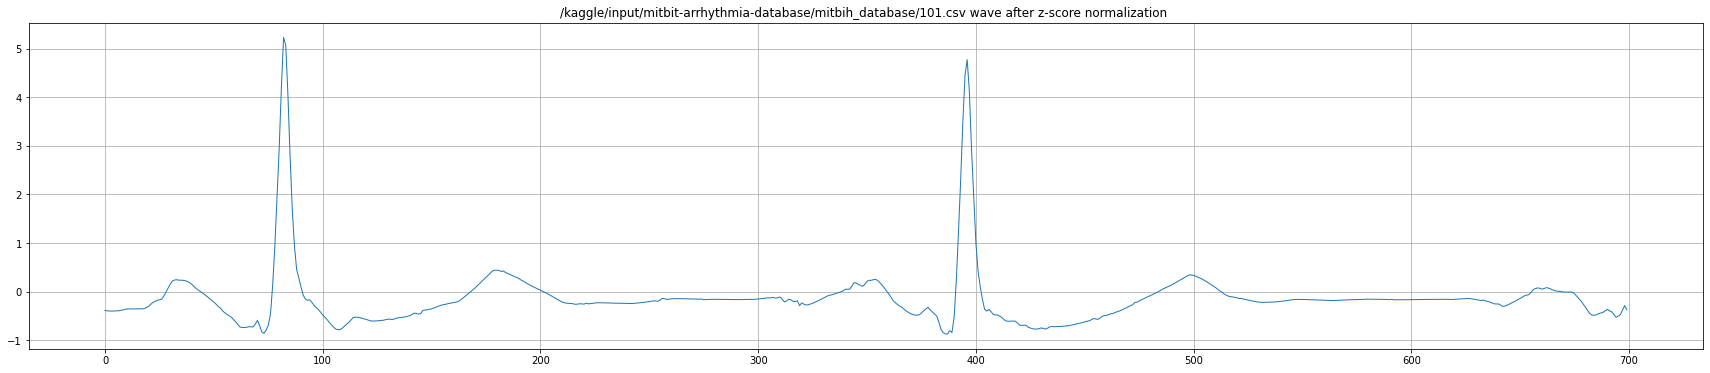

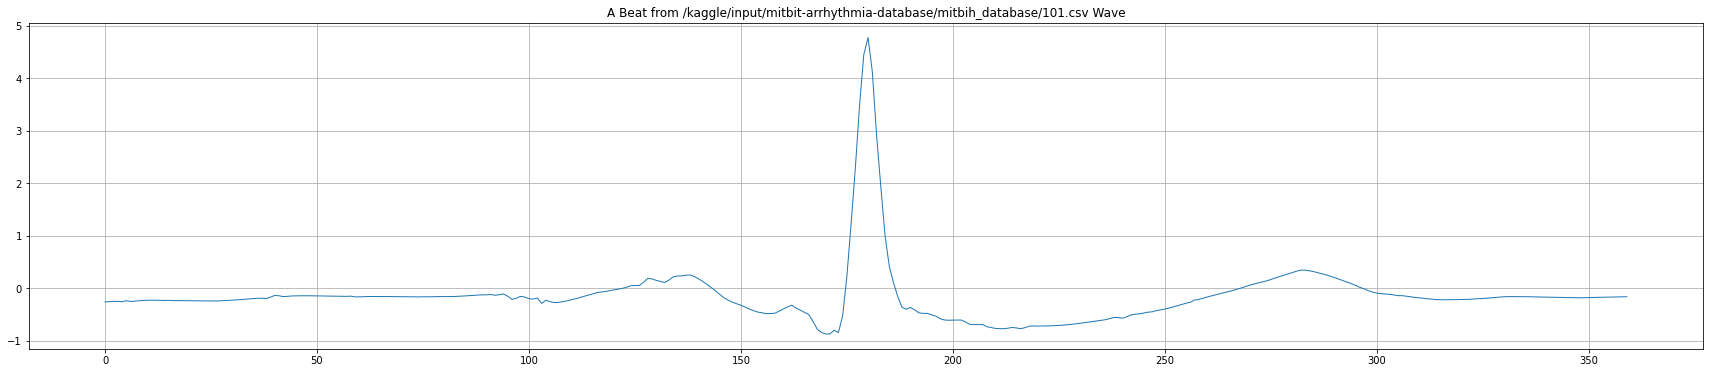

(100012, 360) (100012,)


In [101]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [102]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


# Classes Distribution

In [103]:
# import pandas as pd
# import matplotlib.pyplot as plt

# X_train_df = pd.DataFrame(X)  # Assuming X is your data
# # per_class = X_train_df[X_train_df.shape[1]-1].value_counts()

# # Reduce figure size for a journal
# plt.figure(figsize=(8, 6))

# # Create the pie chart
# plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue',
#                                                             'tab:orange',
#                                                             'tab:purple',
#                                                             'tab:olive',
#                                                             'tab:green'],
#         autopct='%1.1f%%',  # Show percentage with one decimal place
#         wedgeprops=dict(width=0.6))  # Reduce slice width for better readability

# # Add a title for clarity
# plt.title("Distribution of Classes in the Data")

# # Remove unnecessary elements for a cleaner look
# plt.axis('equal')  # Equal aspect ratio ensures a circular pie
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside

# plt.tight_layout()  # Adjust layout to prevent overlapping elements

# plt.show()


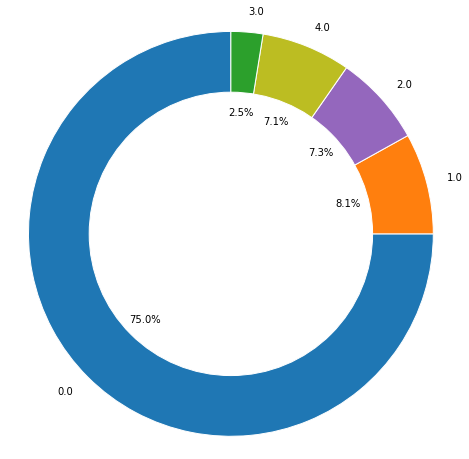

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()

# Define colors
colors = ['tab:blue','tab:orange','tab:purple','tab:olive','tab:green']

# Create a pie plot
plt.figure(figsize=(8, 8))
plt.pie(per_class, labels=per_class.index, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(edgecolor='w', linewidth=1))

# Add circle for better aesthetics
circle = plt.Circle((0, 0), 0.7, color='white')
plt.gca().add_artist(circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Add title
# plt.title('Distribution of Classes', fontsize=16, fontweight='bold')

# Adjust legend font size
# plt.legend(fontsize=12)

# Save the plot
plt.savefig('Distribution_of_data.png', dpi=300, bbox_inches='tight')
plt.show()


0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


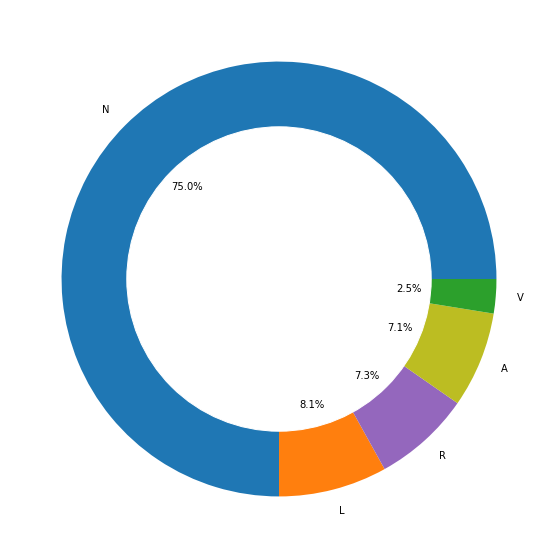

<Figure size 2160x432 with 0 Axes>

In [105]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')

plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


plt.savefig('Distribution of data.png')

# Rebalancing Classes

In [106]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

4.0    5000
3.0    5000
2.0    5000
1.0    5000
0.0    5000
Name: 360, dtype: int64


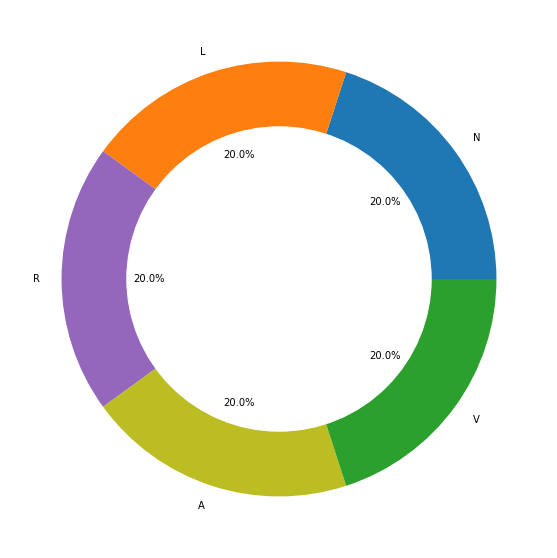

In [107]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

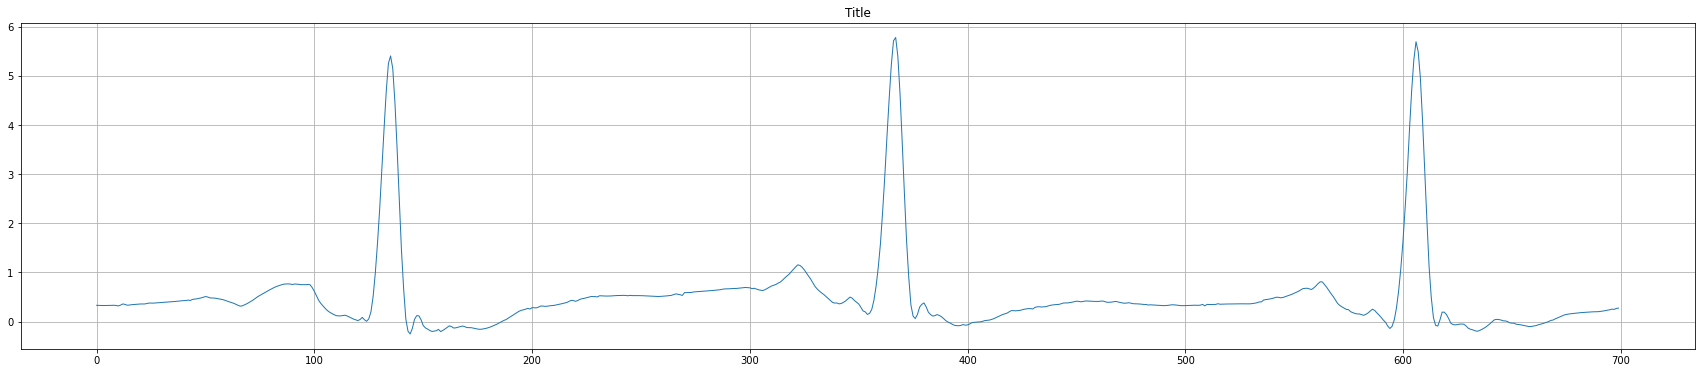

In [108]:
plt.title("Title")
plt.plot(signals[0:700])
plt.show()

# Train-Test Split

In [109]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [110]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [111]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


## Building the Model Architecture


In [112]:
# # Instanciate an empty model
# model = Sequential()

# # Adding a Convolution Layer C1
# # Input shape = N = (360 x 1)
# # No. of filters  = 16
# # Filter size = f = (13 x 1)
# # Padding = true
# # Strides = S = 1
# # Size of each feature map in C1 is (N-f+2P)/S +1 = 360-13+2*6 +1 = 360
# # No. of parameters between input layer and C1 = (13*1 + 1)*16 = 224

# model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))


# # Adding an Average Pooling Layer S2
# # Input shape = N = (360 x 16)
# # No. of filters = 16
# # Filter size = f = (3 x 1)
# # Padding = P = 0
# # Strides = S = 2
# # Size of each feature map in S2 is (N-f+2P+1)/S = (360-3+0+1)/2 = 179
# # No. of parameters between C1 and S2 = (1+1)*16 = 32
# model.add(AvgPool1D(pool_size=3, strides=2))





# # Adding a Convolution Layer C3
# # Input shape = N = (179 x 16)
# # No. of filters  = 32
# # Filter size = f = (15 x 1)
# # Padding = true
# # Strides = S = 1
# # Size of each feature map in C1 is (N-f+2P)/S +1 = 179-15+2*7 +1 = 360
# # No. of parameters between input layer and C1 = (15*1 + 1)*32 = 512
# model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))


# # Adding an Average Pooling Layer S4
# # Input shape = N = (179 x 32)
# # No. of filters = 32
# # Filter size = f = (3 x 1)
# # Padding = P = 0
# # Strides = S = 2
# # Size of each feature map in S2 is (N-f+2P+1)/S = (179-3+0+1)/2 = 89
# # No. of parameters between C1 and S2 = (1+1)*32 = 64
# model.add(AvgPool1D(pool_size=3, strides=2))



# # Adding a Convolution Layer C5
# # Input shape = N = (89 x 32)
# # No. of filters  = 64
# # Filter size = f = (17 x 1)
# # Padding = true
# # Strides = S = 1
# # Size of each feature map in C1 is (N-f+2P)/S +1 = 89-17+2*8 +1 = 89
# # No. of parameters between input layer and C1 = (17*1 + 1)*64 = 1152
# model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))



# # Adding an Average Pooling Layer S6
# # Input shape = N = (89 x 64)
# # No. of filters = 64
# # Filter size = f = (3 x 1)
# # Padding = P = 0
# # Strides = S = 2
# # Size of each feature map in S2 is (N-f+2P+1)/S = (89-3+0+1)/2 = 44
# # No. of parameters between C1 and S2 = (1+1)*64 = 128
# model.add(AvgPool1D(pool_size=3, strides=2))



# # Adding a Convolution Layer C7
# # Input shape = N = (44 x 64)
# # No. of filters  = 128
# # Filter size = f = (19 x 1)
# # Padding = true
# # Strides = S = 1
# # Size of each feature map in C1 is (N-f+2P)/S +1 = 44-19+2*9 +1 = 44
# # No. of parameters between input layer and C1 = (19*1 + 1)*128 = 2560
# model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))


# # Adding an Average Pooling Layer S8
# # Input shape = N = (44 x 128)
# # No. of filters = 128
# # Filter size = f = (3 x 1)
# # Padding = P = 0
# # Strides = S = 2
# # Size of each feature map in S2 is (N-f+2P+1)/S = (44-3+0+1)/2 = 21
# # No. of parameters between C1 and S2 = (1+1)*128 = 256
# model.add(AvgPool1D(pool_size=3, strides=2))



# # Flattening the layer 
# # There would be 128*(21*1) = 2688 neurons
# model.add(Flatten())


# # Dropout the layer S9
# model.add(Dropout(0.5))



# # Adding a Dense layer with regularization l2(0.0001)# S10
# # No. of inputs = 2688
# # No. of outputs = 35
# # No. of parameters = 2688 x 35 + 35 = 94115
# model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# # Adding a Dense layer with regularization l2(0.0001)# S11
# # No. of inputs = 35
# # No. of outputs = 5
# # No. of parameters = 35*5 + 5 = 180
# model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# # Adding a Softmax layer S12
# # No. of inputs = 5
# # No. of outputs = 5
# model.add(Softmax())


# model.summary()

# Correct Model

In [113]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, AvgPool1D, Flatten, Dropout, Dense, LSTM
from tensorflow.keras.regularizers import l2

# Instantiate the sequential model
model = Sequential()

# Convolutional layers (unchanged from your original code)
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu', input_shape=(360, 1)))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))

# LSTM layer for capturing temporal relationships
model.add(LSTM(128, return_sequences=True))  # Experiment with return_sequences
model.add(LSTM(64,return_sequences=True))  # Experiment with return_sequences
model.add(LSTM(32)) 
# Rest of the layers (unchanged from your original code)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(35, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001)))
model.add(Dense(5, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001)))
model.add(Softmax())

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 360, 16)           224       
_________________________________________________________________
average_pooling1d_8 (Average (None, 179, 16)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 179, 32)           7712      
_________________________________________________________________
average_pooling1d_9 (Average (None, 89, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 89, 64)            34880     
_________________________________________________________________
average_pooling1d_10 (Averag (None, 44, 64)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 44, 128)          

## Compiling the model

In [114]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

In [115]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [116]:
# k-fold
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold
kfold = KFold(n_splits=5,shuffle=True,random_state=42)

In [117]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

## Fitting the model

In [118]:
history = model.fit(train_x, train_y, batch_size=36, epochs=60, verbose=1, validation_data=(test_x, test_y))

Epoch 1/60
556/556 [==============================] - 11s 13ms/step - loss: 1.5998 - accuracy: 0.2457 - val_loss: 1.4441 - val_accuracy: 0.4082
Epoch 2/60
556/556 [==============================] - 6s 11ms/step - loss: 1.3852 - accuracy: 0.4253 - val_loss: 1.1313 - val_accuracy: 0.5532
Epoch 3/60
556/556 [==============================] - 6s 11ms/step - loss: 1.0399 - accuracy: 0.5993 - val_loss: 0.7043 - val_accuracy: 0.7806
Epoch 4/60
556/556 [==============================] - 6s 10ms/step - loss: 0.7047 - accuracy: 0.7685 - val_loss: 0.3880 - val_accuracy: 0.8810
Epoch 5/60
556/556 [==============================] - 6s 10ms/step - loss: 0.4916 - accuracy: 0.8473 - val_loss: 0.7558 - val_accuracy: 0.7278
Epoch 6/60
556/556 [==============================] - 6s 11ms/step - loss: 0.3781 - accuracy: 0.8878 - val_loss: 0.3312 - val_accuracy: 0.8908
Epoch 7/60
556/556 [==============================] - 6s 11ms/step - loss: 0.3170 - accuracy: 0.9108 - val_loss: 0.4804 - val_accuracy: 0.836

**Plotting the loss convergence**

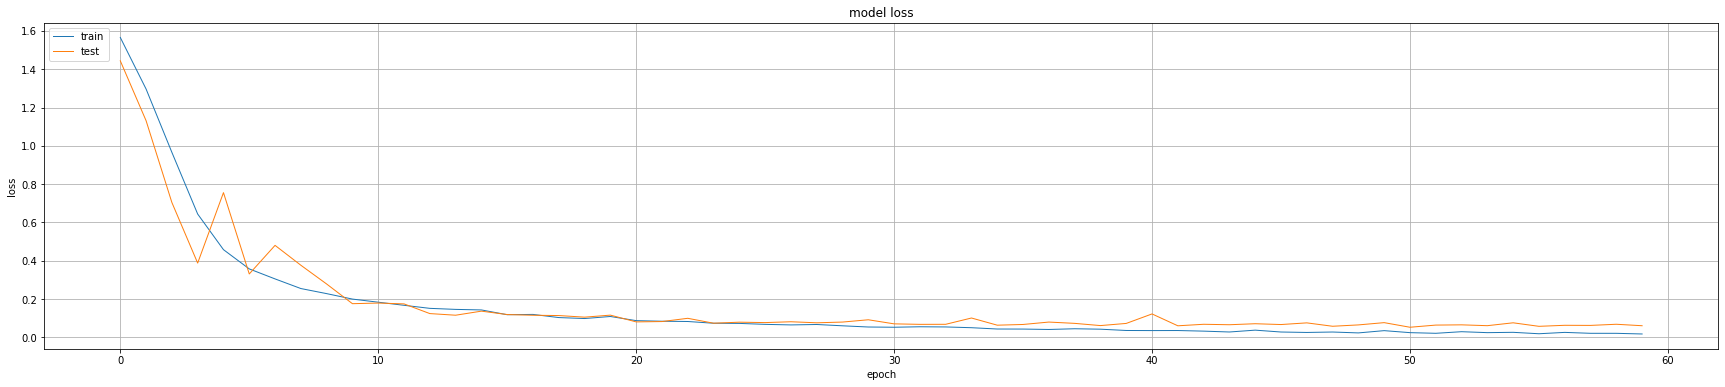

In [119]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Plotting accuracy**

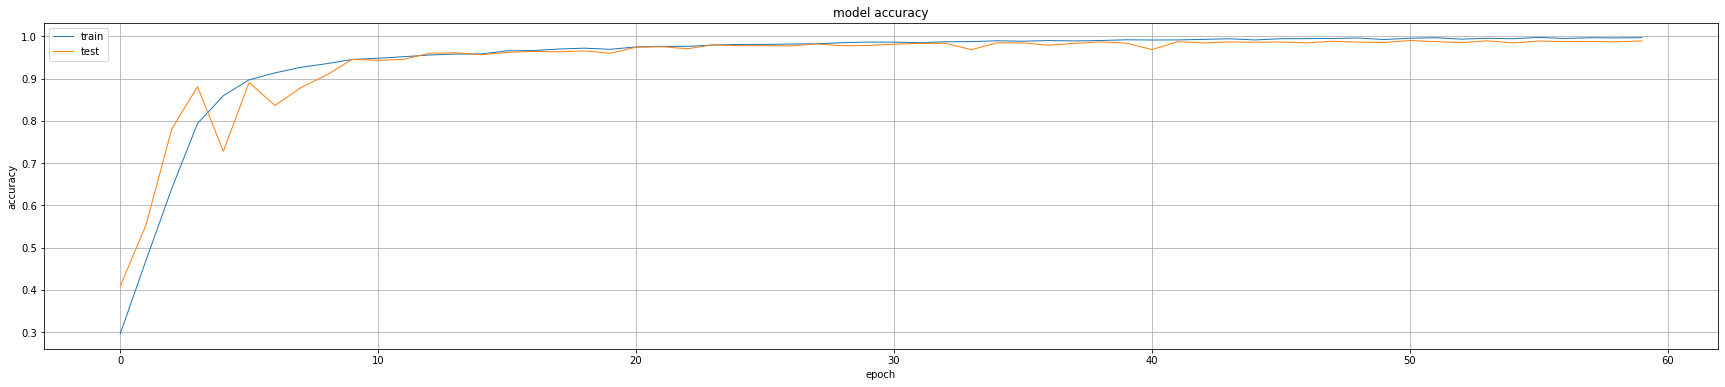

In [120]:
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Finding the loss and accuracy of the model

In [121]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 1s 5ms/step - loss: 0.0609 - accuracy: 0.9894
Test Loss: 0.060863666236400604
Test accuracy: 0.9894000291824341


In [122]:
X_test_pred=model.predict(test_x)

X_test_pred

array([[5.7123458e-07, 2.5313220e-06, 3.5128529e-09, 1.1397415e-06,
        9.9999571e-01],
       [6.6822840e-06, 1.5933985e-11, 2.5922197e-06, 9.9998772e-01,
        2.9629812e-06],
       [4.1524095e-06, 9.9999249e-01, 1.8249401e-06, 1.3529984e-10,
        1.5199149e-06],
       ...,
       [7.9066005e-05, 3.6728682e-06, 9.9959296e-01, 3.2405439e-04,
        3.2698347e-07],
       [9.9978691e-01, 2.4763976e-05, 4.3286473e-06, 1.2641044e-04,
        5.7515404e-05],
       [1.5132778e-03, 9.7809991e-09, 2.4534231e-05, 9.9839067e-01,
        7.1571405e-05]], dtype=float32)

In [123]:
X_test_pred=np.argmax(X_test_pred, axis=1)

In [124]:
test_y=np.argmax(test_y, axis=1)

#  **Precision**

In [125]:
from sklearn.metrics import precision_score 

In [126]:
precision=precision_score(test_y,X_test_pred,average='macro')
precision

0.9894522806137303

# Recall

In [127]:
from sklearn.metrics import recall_score

In [128]:
recall=recall_score(test_y,X_test_pred,average='macro')

recall

0.9894052491750435

In [129]:
from sklearn.metrics import f1_score

In [130]:
f1=f1_score(test_y,X_test_pred,average='macro')

f1

0.989423998355211

In [137]:
print("****************************************************")
print("\033[1mModel Performance Meterics\033[0m")
print(f"Accuracy Score: {score[1]}")
print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"F1 Score: {f1}")


print("****************************************************")

****************************************************
Model Performance Meterics
Accuracy Score: 0.9894000291824341
Precision Score: 0.9894522806137303
Recall Score: 0.9894052491750435
F1 Score: 0.989423998355211
****************************************************


In [132]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [133]:
conf_mat=confusion_matrix(test_y,X_test_pred)


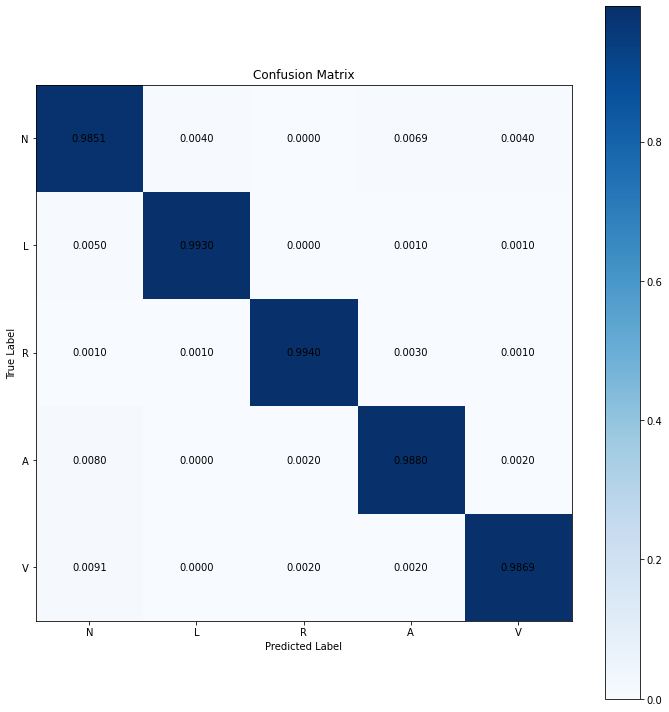

In [134]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix (replace with your data)


# Normalize the confusion matrix
cm_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Create a new figure
plt.figure(figsize=(10, 10))

# Create heatmap without grid lines
plt.imshow(cm_norm, cmap=plt.cm.Blues)  # Set grid to False
plt.grid(False)

# Add labels and title 
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')


# Loop through the data and create text annotations.
for i in range(len(cm_norm)):
    for j in range(len(cm_norm)):
        plt.text(j, i, "{:0.4f}".format(cm_norm[i, j]), va='center', ha='center')

# Add colorbar
plt.colorbar()

# Fix tick labels
tick_labels = ['N', 'L', 'R', 'A', 'V']
plt.xticks(np.arange(len(tick_labels)), tick_labels)
plt.yticks(np.arange(len(tick_labels)), tick_labels)

# Fine-tune the plot
plt.tight_layout()
plt.show()

